# Library function is working properly?

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch

sys.path.append('../src')
from deepymod_torch.library_function import strain_input_library
from deepymod_torch.DeepMod import DeepMoD_no_equation

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

This notebook aims to test the accuracy of the library function `mech_library`. It does this broadly by computing teh numerical derivatives of stress and strain using numpy from the raw data, then training a NN to match the noiseless data, and using the `mech_library` to calculate the derivatives using the network. The two results are then compared.

First, set up analytical parameters for `library_config`.

In [2]:
Input_Type = 'Strain'
Input_Function = lambda time_data: torch.sin(time_data)/time_data

Load data

In [3]:
data = np.loadtxt('../data/StressStrain/Strain Sinc E[1, 1, 1] V[1.25, 2.5].csv', delimiter=',')
time_array, strain_array, stress_array = data[:,0:1], data[:,1:2], data[:,2:]

Define function for taking a column of data and a column of independant variable and numerically calcuating the derivative of this data with respect to teh independant veraiable up to a specified order, and returning this as a 2D array where the number of columns = the order of max derivative + 1.

In [4]:
def num_derivs(dependent_data, independent_data, diff_order):
    
    data_derivs = dependent_data.copy()
    for _ in range(diff_order):
        data_derivs = np.append(data_derivs, np.gradient(data_derivs[:, -1].flatten(), independent_data.flatten()).reshape(-1,1), axis=1)
    
    return data_derivs

Use this function to calculate the derivatives for strain and stress, and then combine these into a full library of numerical results.

In [5]:
diff_order = 3

strain_theta = num_derivs(strain_array, time_array, diff_order)
stress_theta = num_derivs(stress_array, time_array, diff_order)
num_theta = np.append(strain_theta, stress_theta, axis=1)
num_theta.shape

(5000, 8)

(-1, 1)

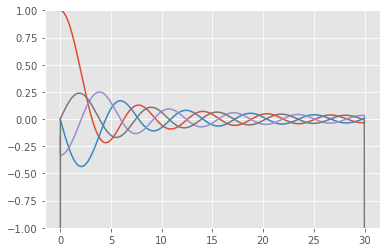

In [6]:
for idx in np.arange(strain_theta.shape[1]):
    plt.plot(time_array, strain_theta[:, idx])
plt.ylim([-1, 1])

(-1, 1)

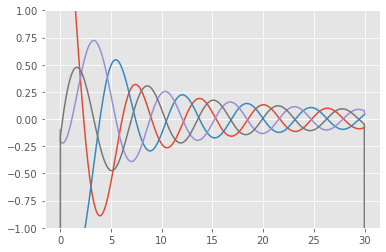

In [7]:
for idx in np.arange(stress_theta.shape[1]):
    plt.plot(time_array, stress_theta[:, idx])
plt.ylim([-1, 1])

randomly sample from the data set, ready to feed a subset to the NN, and select only the corresponding rows from the numerical library to keep for comparison.

or

In [8]:
reduced_time_array = time_array
reduced_stress_array = stress_array
reduced_num_theta = num_theta

Prep for NN, convert to tensors

In [9]:
time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
stress_tensor = torch.tensor(reduced_stress_array, dtype=torch.float32)

More prep, standard config dictionaries save for `diff_order` automatically matching the diff order used to get the numerical library, and an increased maximum epoch.

In [10]:
optim_config = {'lambda': 10**-5, 'max_iterations': 50001}
network_config = {'input_dim': 1, 'hidden_dim': 25, 'layers': 5, 'output_dim': 1}
library_config = {'type': strain_input_library, 'diff_order': diff_order, 'coeff_sign': 'positive', 'input_type': Input_Type, 'input_expr': Input_Function}

Use modified DeepMoD protocol. doesn't return coeffs as most reference to this is gone. Instead returns the full library obtained automatic differentiation and from `mech_library` and based on the prediction at the final epoch.

Epoch | MSE loss 
50000 5.8E-06
lr is 0.0001
Time elapsed: 122.0 minutes 19.975066661834717 seconds


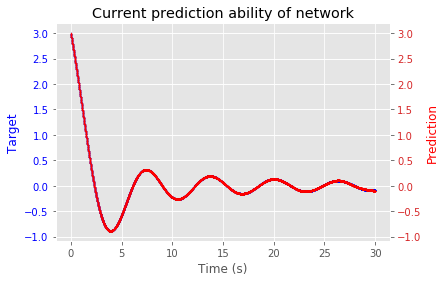

In [11]:
network, auto_theta = DeepMoD_no_equation(time_tensor, stress_tensor, network_config, library_config, optim_config)

In [12]:
auto_theta_array = np.array(auto_theta)
auto_theta_array.shape

(5000, 8)

Compute the piecewise difference between the numerical and automatic libraries and examine.

In [13]:
diff = auto_theta_array - reduced_num_theta
diff

array([[ 4.74573688e-08,  9.67285761e-04,  4.16639159e-02, ...,
         9.97678336e-02, -4.55056711e+00,  1.00503430e+02],
       [ 3.14427961e-09, -9.47835360e-07, -8.20383771e-02, ...,
         7.40965287e-02, -3.95769965e+00,  9.69748112e+01],
       [ 4.17052461e-08,  4.15165630e-07, -6.70347347e-04, ...,
         5.22194067e-02, -3.38824617e+00,  8.84846925e+01],
       ...,
       [-6.52331701e-09,  1.75041786e-08,  3.88030872e-07, ...,
        -6.30688941e-02, -6.21807647e-02,  1.58669208e+00],
       [ 4.47062155e-09,  6.52585261e-08,  8.12996068e-03, ...,
        -6.34413826e-02, -4.33474759e-02,  3.12649691e+00],
       [ 1.18660280e-09,  9.76220010e-05,  1.62343642e-02, ...,
        -6.35891378e-02, -2.46565520e-02,  3.11467057e+00]])

In [14]:
np.mean(diff**2, axis=0)

array([3.43647161e-16, 1.89292829e-10, 1.75926919e-06, 8.69055622e-02,
       5.79498405e-06, 7.18966589e-05, 1.54843899e-02, 1.19607741e+01])

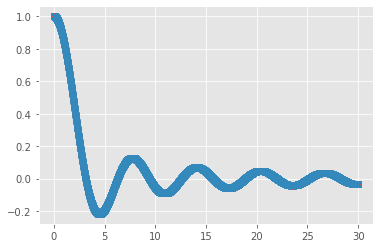

In [15]:
idx = 0 
plt.plot(reduced_time_array, reduced_num_theta[:, idx], 'o')
plt.plot(reduced_time_array, auto_theta_array[:, idx], 'x')

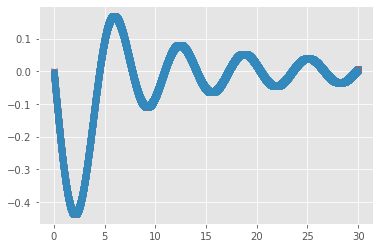

In [16]:
idx = 1
plt.plot(reduced_time_array, reduced_num_theta[:, idx], 'o')
plt.plot(reduced_time_array, auto_theta_array[:, idx], 'x')

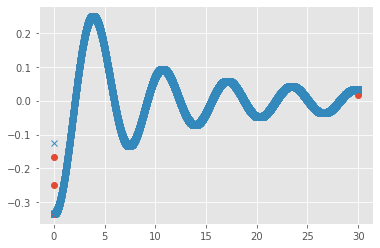

In [17]:
idx = 2
plt.plot(reduced_time_array, reduced_num_theta[:, idx], 'o')
plt.plot(reduced_time_array, auto_theta_array[:, idx], 'x')

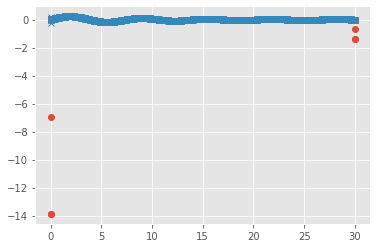

In [18]:
idx = 3
plt.plot(reduced_time_array, reduced_num_theta[:, idx], 'o')
plt.plot(reduced_time_array, auto_theta_array[:, idx], 'x')

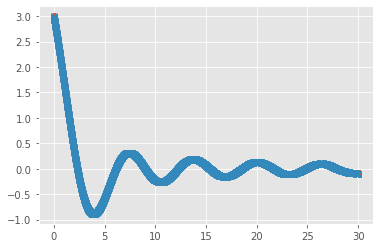

In [19]:
idx = 4
plt.plot(reduced_time_array, reduced_num_theta[:, idx], 'o')
plt.plot(reduced_time_array, auto_theta_array[:, idx], 'x')

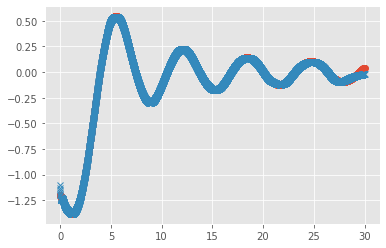

In [20]:
idx = 5
plt.plot(reduced_time_array, reduced_num_theta[:, idx], 'o')
plt.plot(reduced_time_array, auto_theta_array[:, idx], 'x')

(-1, 1)

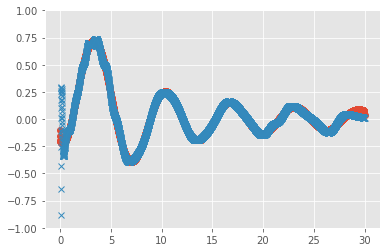

In [21]:
idx = 6
plt.plot(reduced_time_array, reduced_num_theta[:, idx], 'o')
plt.plot(reduced_time_array, auto_theta_array[:, idx], 'x')
plt.ylim([-1, 1])

(-1, 1)

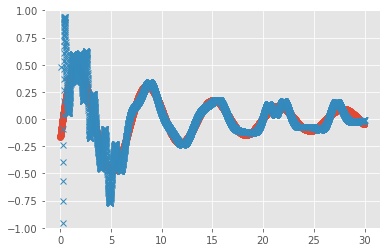

In [22]:
idx = 7
plt.plot(reduced_time_array, reduced_num_theta[:, idx], 'o')
plt.plot(reduced_time_array, auto_theta_array[:, idx], 'x')
plt.ylim([-1, 1])

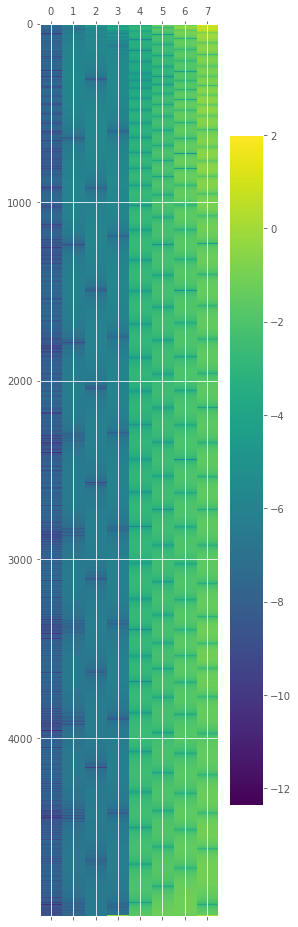

In [23]:
plt.matshow(np.log10(abs(diff)), aspect='auto')
plt.colorbar()